In [ ]:
# Transformers installation
! pip install transformers datasets accelerate evaluate -U

# 1) Encoder-Only LLMs

## Load Emotion dataset

Nous allons charger un dataset de SentimentAnalysis (i.e. contenant des phrases et un label d'émotion associé à chaque phrase).

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions["train"] = emotions["train"].select(range(10000))
emotions["validation"] = emotions["validation"].select(range(1000))
emotions["test"] = emotions["test"].select(range(10))

Regardons un peu ce que contient le dataset.

In [ ]:
emotions["validation"][0]

In [ ]:
emotions["validation"].features

Il est possible de transformer le dataset HuggingFace en un Pandas DataFrame très facilement:

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

Remplaçons maintenan les label par leur nom:

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## Load a pretrained model

Chargeons maintenant un modèle Bert.

In [ ]:
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions.set_format("pytorch")
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Commençons par regarder comment charger le Transformer seul:

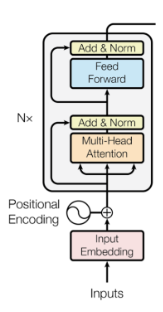

In [ ]:
# hide_output
from transformers import AutoModel, AutoModelForSequenceClassification

headless_model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
headless_model

Puis le Transformer avec un MLP pour faire la tâche de classification:

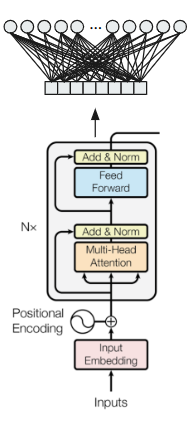

In [ ]:
num_labels = len(emotions["validation"].features["label"].names)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Notez ci-dessus me message indiquant que les poids du MLP ne sont pas pré-entraînés.

In [ ]:
model

Nous pouvons entraîner ce modèle sur le dataset chargé.

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

In [ ]:
from transformers import Trainer

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Regardons les performances sur le test set:

In [ ]:
preds_output = trainer.predict(emotions_encoded["test"])
print(preds_output.metrics)

# 2) Decoder-Only

Passons maintenant à un modèle Decoder-Only (aussi appelé Causal LM) avec GPT-2.

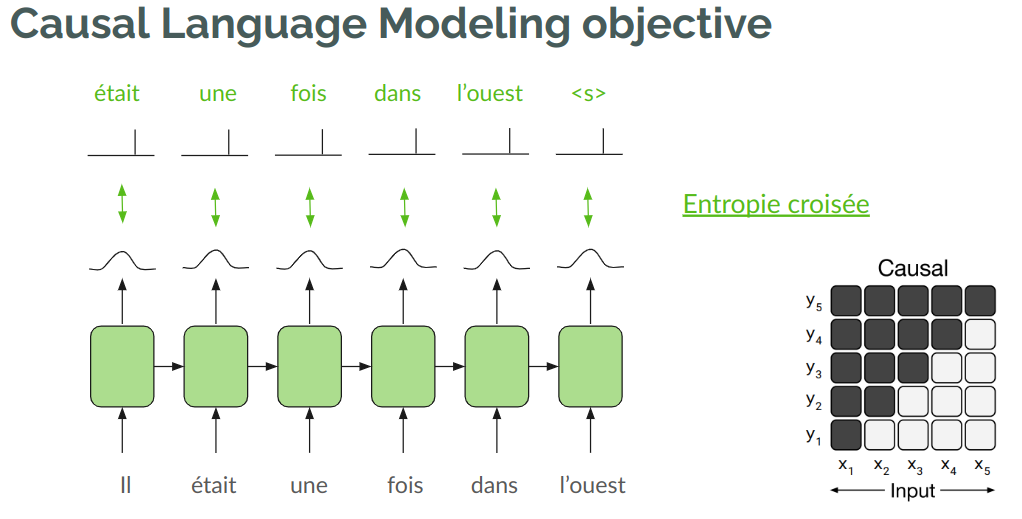

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
torch.manual_seed(42)

Regardons maintenant les tokens les plus probables selon GPT-2 lorsqu'on lui donne en entrée la phrase "Transformers are the".

Essayez ensuite d'autres phrases (par exemple en Français).

In [ ]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits for the last token
        next_token_logits = output.logits[0, -1, :]
        # Apply softmax to get a normalized distribution
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

Dans le morceau de code ci-dessus, le token le plus probable est utilisé pour continuer la phrase. Cette méthode est appelée Greedy Search Decoding.

## Greedy Search Decoding

La librairie transformers possède une méthode "generate" sur les Causal LMs permettant de continuer une phrase. Voici comment continuer la phrase avec du Greedy Search Decoding:

In [ ]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
max_new_tokens = 8
output = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=False)
print(tokenizer.decode(output[0]))

En réalité, on a plutôt tendance à tirer un token de la distribution au lieu de choisir le plus probable. Il est possible de contrôler à quel point la distribution est piquée autour des tokens les plus probables grâce à un paramètre de température appliqué à la softmax.

## Sampling temperature

Regardons un petit peu l'effet de la temperature sur les écarts de probabilité:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

Ainsi, une temperature > 1 rendra la distribution plus uniforme et une temperature entre 0 et 1 la rendra plus piquée.

Voici ce que ça donne avec notre modèle:

In [ ]:
output_temp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In [ ]:
output_temp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

On peut aller encore plus loin. Le nombre de tokens possibles étant généralement très grand (e.g. 50000), il peut être souhaitable de se concentrer sur un sous-ensemble probable.

Pour cela, le Top-k et Top-p (aussi appelé Nucleus) sampling permettent d'échantillonner un token d'une distribution contenant seulement:
- les k tokens les plus probables (Top-k)
- le plus petit ensemble de tokens dont la somme des probabilités atteint p (Top-p)

## Top-k and Nucleus Sampling

In [ ]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

Testons avec notre modèle.

Commençons par un Top-k:

In [ ]:
output_topk = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

Puis le Top-p:

In [ ]:
output_topp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, top_p=0.90)
print(tokenizer.decode(output_topp[0]))